In [ ]:
'''
article: https://towardsdatascience.com/demand-prediction-with-lstms-using-tensorflow-2-and-keras-in-python-1d1076fc89a0
'''

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
df = pd.read_csv(
    'Resources/london_merged.csv',
    parse_dates = ['timestamp'],
    index_col = 'timestamp'
)

In [4]:
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [6]:
df.shape

(17414, 9)

In [7]:
'''
categories:
* timestamp — timestamp field for grouping the data
* cnt — the count of a new bike shares
* t1 — real temperature in C
* t2 — temperature in C “feels like”
* hum — humidity in percentage
* wind_speed — wind speed in km/h
* weather_code — category of the weather
* is_holiday — boolean field — 1 holiday / 0 non holiday
* is_weekend — boolean field — 1 if the day is weekend
* season — category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.
'''

'\ncategories:\n* timestamp — timestamp field for grouping the data\n* cnt — the count of a new bike shares\n* t1 — real temperature in C\n* t2 — temperature in C “feels like”\n* hum — humidity in percentage\n* wind_speed — wind speed in km/h\n* weather_code — category of the weather\n* is_holiday — boolean field — 1 holiday / 0 non holiday\n* is_weekend — boolean field — 1 if the day is weekend\n* season — category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.\n'

In [8]:
df['hour'] = df.index.hour
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

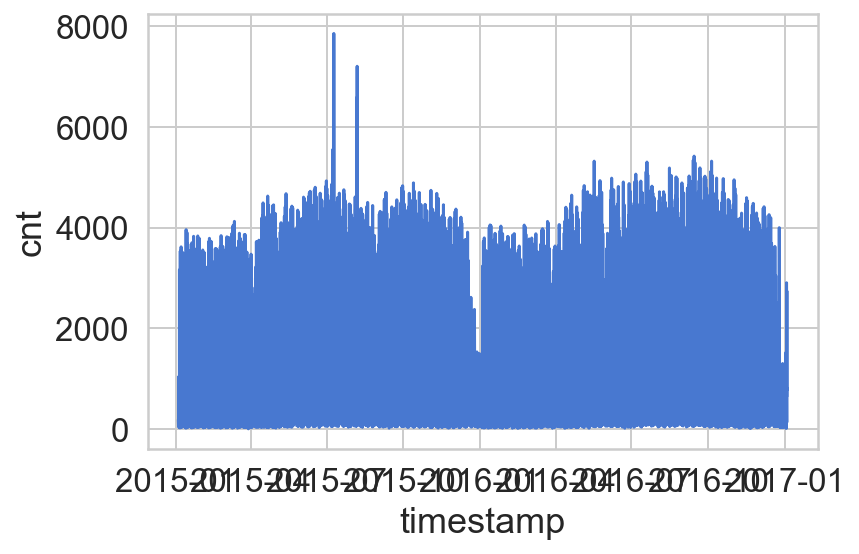

In [11]:
sns.lineplot(x = df.index, y = "cnt", data = df)

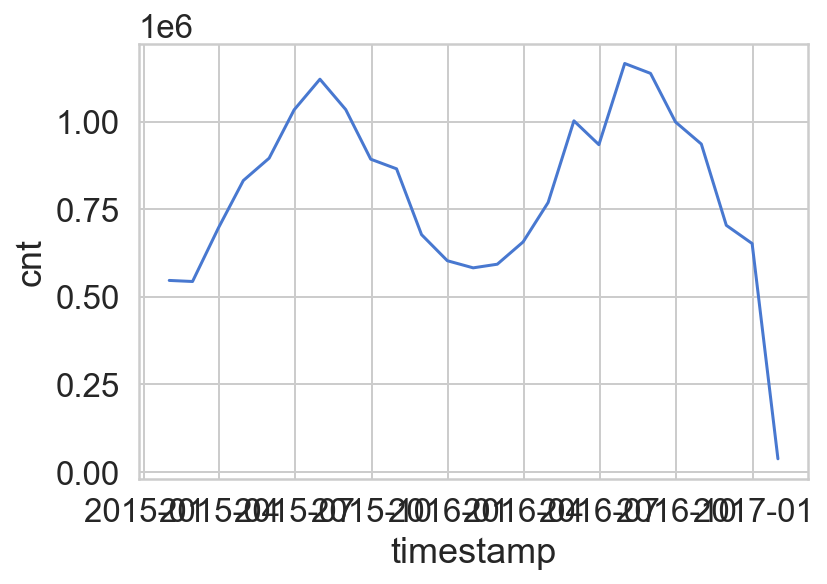

In [15]:
df_by_month = df.resample('M').sum()

sns.lineplot(x = df_by_month.index, y = "cnt", data = df_by_month)

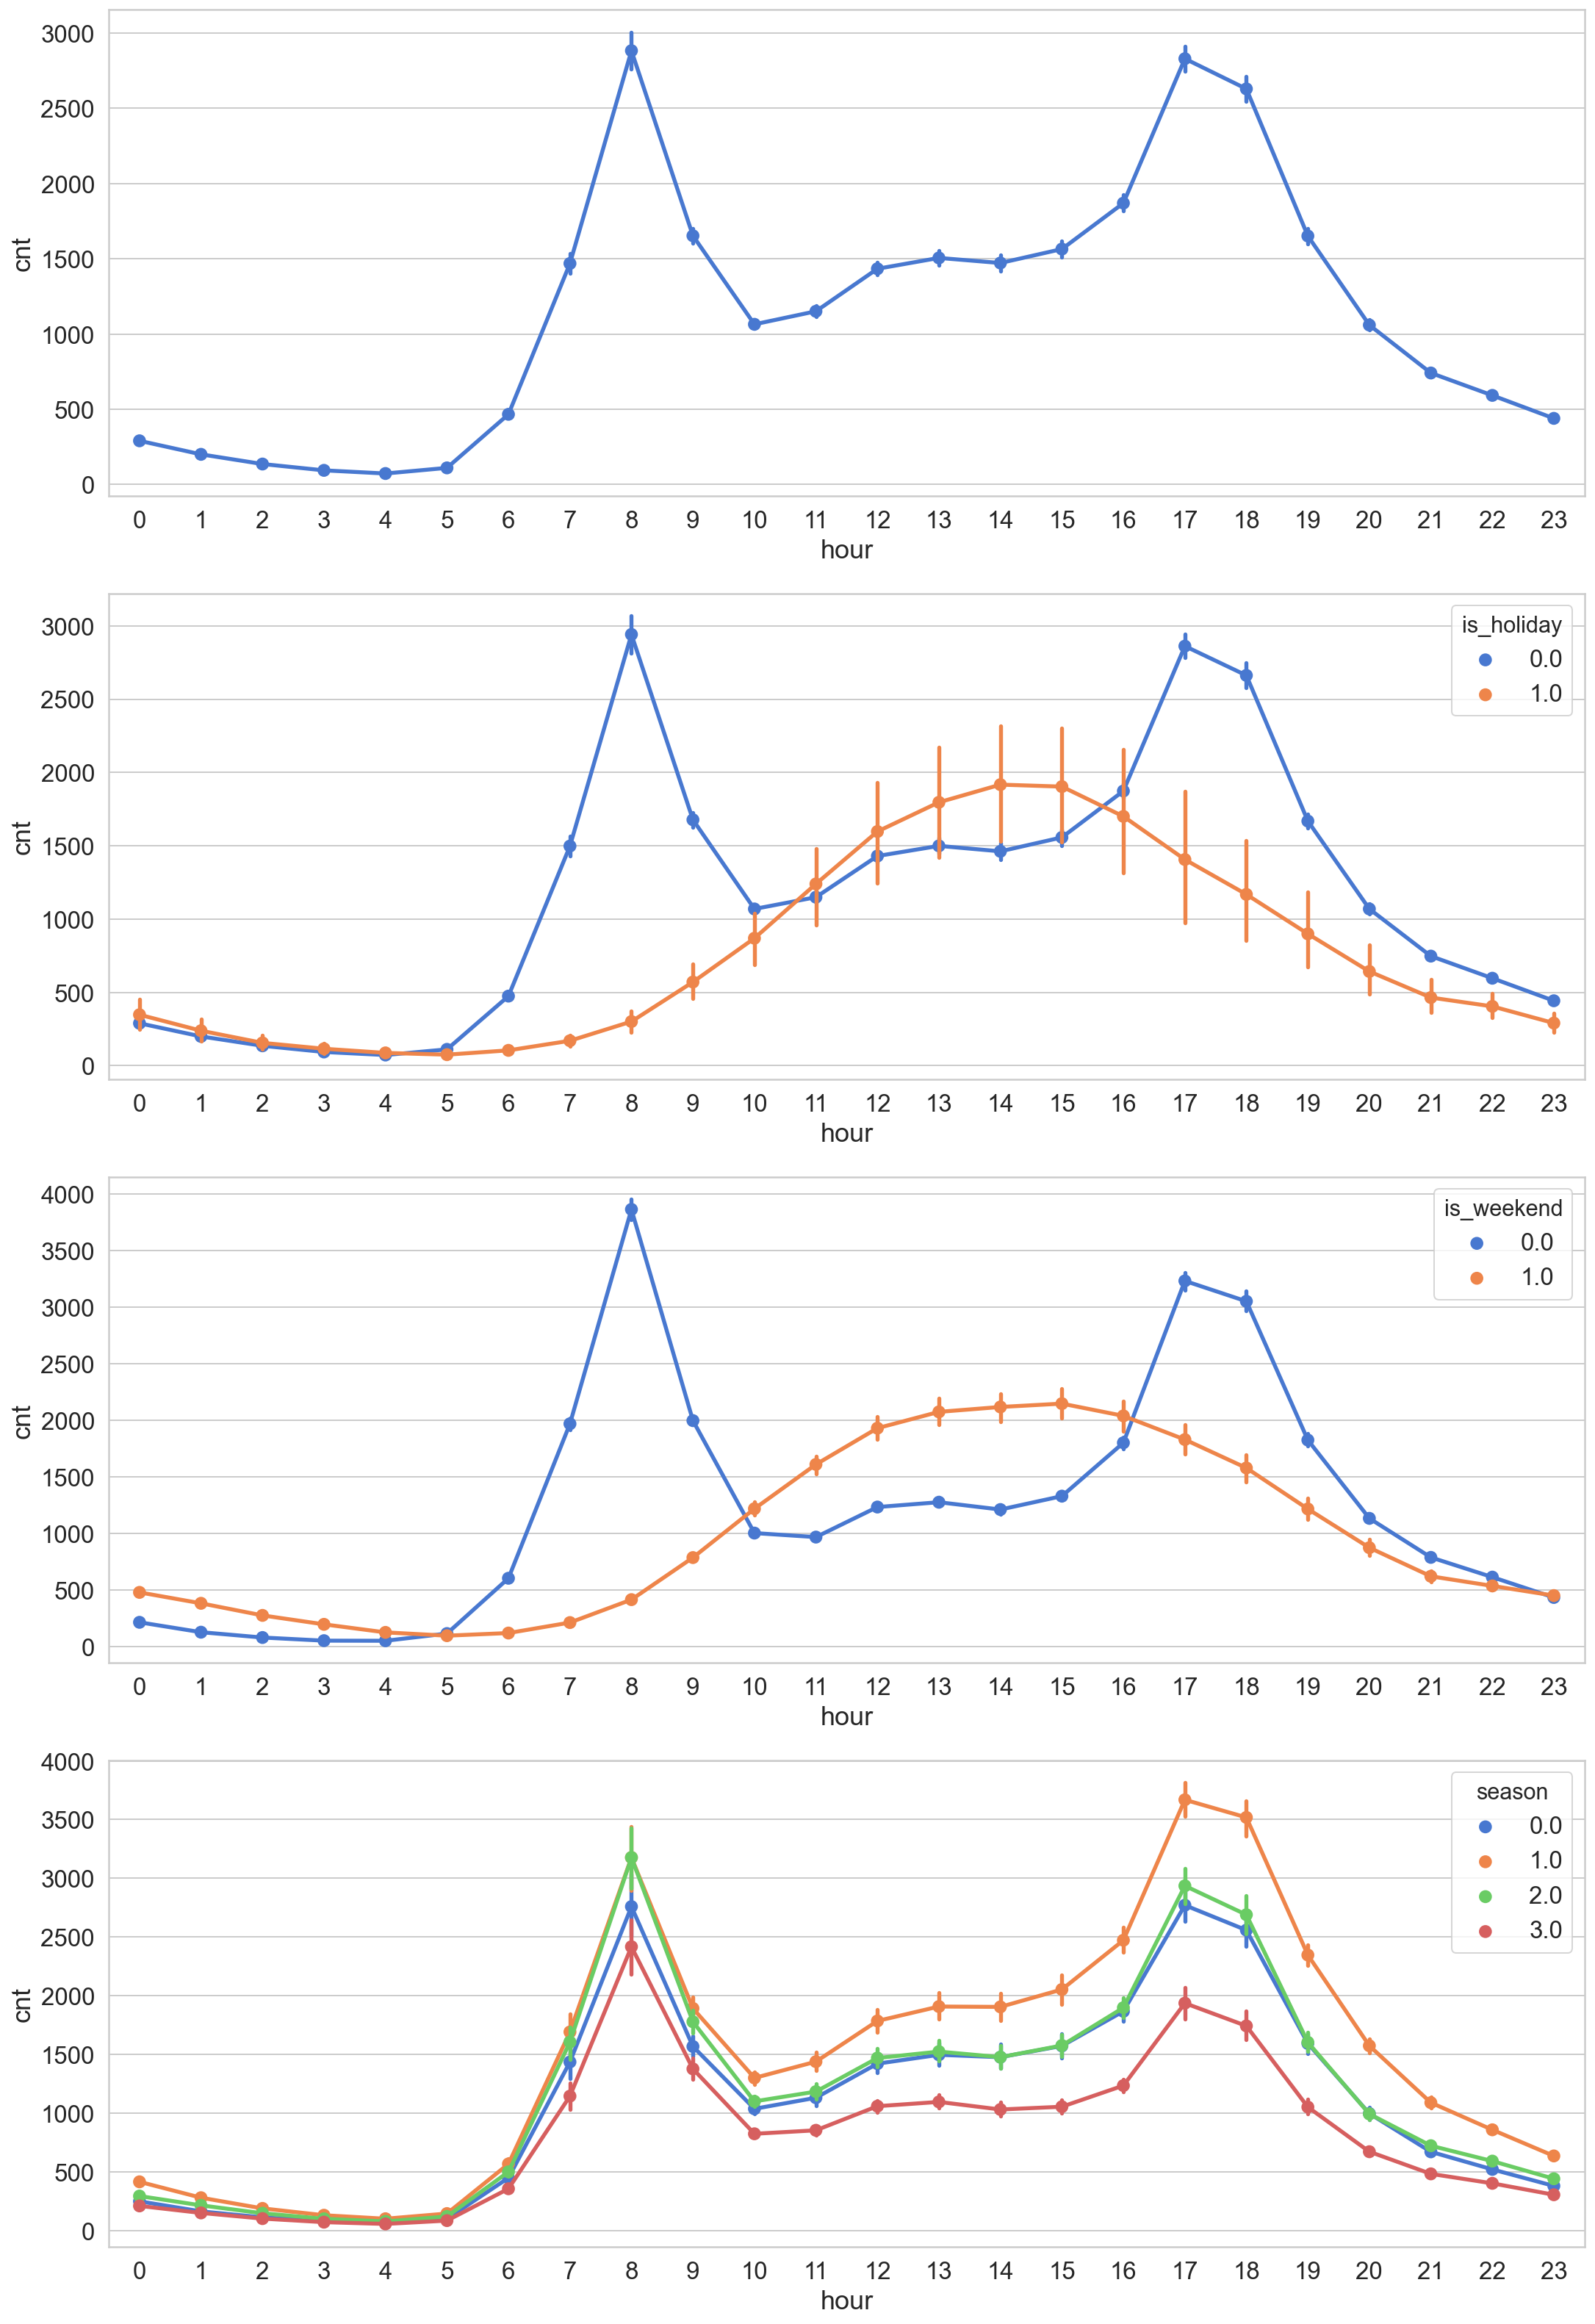

In [16]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 4)
fig.set_size_inches(18, 28)

sns.pointplot(data = df, x = 'hour', y = 'cnt', ax = ax1)
sns.pointplot(data = df, x = 'hour', y = 'cnt', hue = 'is_holiday', ax = ax2)
sns.pointplot(data = df, x = 'hour', y = 'cnt', hue = 'is_weekend', ax = ax3)
sns.pointplot(data = df, x = 'hour', y = 'cnt', hue = 'season', ax = ax4)

In [18]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0: train_size], df.iloc[train_size: len(df)]
print(len(train), len(test))

15672 1742


In [20]:
from sklearn.preprocessing import RobustScaler

f_columns = ['t1', 't2', 'hum', 'wind_speed']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['cnt']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['cnt'] = cnt_transformer.transform(train[['cnt']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['cnt'] = cnt_transformer.transform(test[['cnt']])

In [22]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [23]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.cnt, time_steps)
X_test, y_test = create_dataset(test, test.cnt, time_steps)

print(X_train.shape, y_train.shape)

(15662, 10, 13) (15662,)


In [25]:
model = keras.Sequential()
model.add(keras.layers.Bidirectional(
    keras.layers.LSTM(
        units = 128,
        input_shape = (X_train.shape[1], X_train.shape[2])
    )
))
model.add(keras.layers.Dropout(rate = 0.2))
model.add(keras.layers.Dense(units = 1))
model.compile(loss = 'mean_squared_error', optimizer = 'Adam')

In [26]:
history = model.fit(
    X_train, y_train,
    epochs = 30,
    batch_size = 32,
    validation_split = 0.1,
    shuffle = False
)

Epoch 1/30
441/441 [==============================] - 17s 38ms/step - loss: 0.4670 - val_loss: 0.1255
Epoch 2/30
441/441 [==============================] - 11s 25ms/step - loss: 0.0972 - val_loss: 0.0661
Epoch 3/30
441/441 [==============================] - 11s 25ms/step - loss: 0.0548 - val_loss: 0.0552
Epoch 4/30
441/441 [==============================] - 11s 26ms/step - loss: 0.0426 - val_loss: 0.0355
Epoch 5/30
441/441 [==============================] - 11s 26ms/step - loss: 0.0317 - val_loss: 0.0309
Epoch 6/30
441/441 [==============================] - 11s 24ms/step - loss: 0.0273 - val_loss: 0.0306
Epoch 7/30
441/441 [==============================] - 11s 26ms/step - loss: 0.0292 - val_loss: 0.0319
Epoch 8/30
441/441 [==============================] - 11s 25ms/step - loss: 0.0241 - val_loss: 0.0315
Epoch 9/30
441/441 [==============================] - 11s 26ms/step - loss: 0.0225 - val_loss: 0.0320
Epoch 10/30
441/441 [==============================] - 11s 25ms/step - loss: 0.020

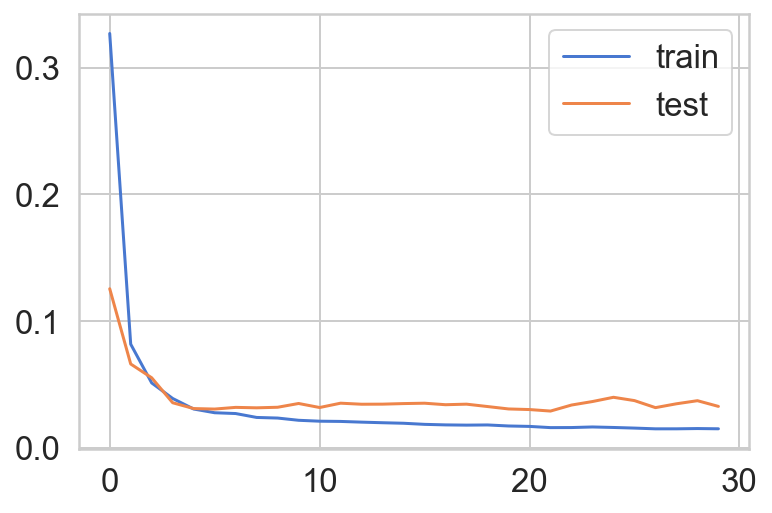

In [27]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [28]:
y_pred = model.predict(X_test)

In [29]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

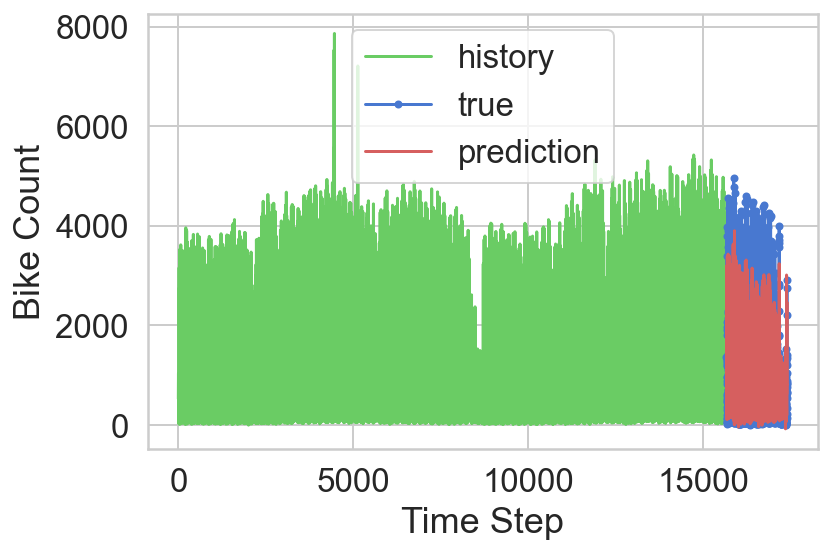

In [30]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

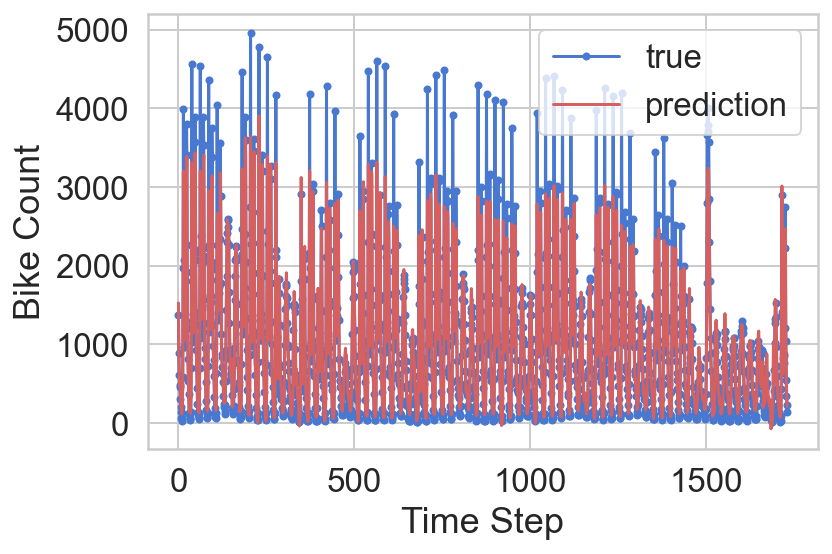

In [31]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();